# Visión por Computador - Práctica 1 - Filtrado de Imágenes

#### 10 puntos   |   Fecha de entrega: 22 de Octubre, 23:59   |   Forma de entrega: a través de la tarea creada en https://pradogrado2324.ugr.es/

### Estudiante: Javier Moreno Morón





---



## Normas de entrega

Para este trabajo, al igual que para los demás, se debe presentar código, resultados, discusión de los mismos, y presentación y análisis del trabajo realizado, todo integrado en este mismo Google Colab Notebook. Se recuerda que código y resultados sin informe explicativo no puntúa.

Este trabajo de implementación tiene como objetivo principal familiarizarse con la implementación y uso de filtros de convolución, así como del cálculo de las derivadas de una imagen y sus posibles aplicaciones.

El diseño de celdas del documento debe ser respetado.

Solo se entregará el código fuente (fichero .ipynb incorporando código, resultados, y explicación del trabajo realizado y los resultados obtenidos) y no se enviarán las imágenes empleadas.

El path para la lectura de imágenes, o cualquier otro fichero de entrada, debe ser siempre “/content/drive/My Drive/images/nombre_fichero”

El código deberá  presentarse con los resultados obtenidos en cada apartado junto con los  correspondientes comentarios y valoraciones. De nuevo, recuerde que la entrega de código sin informe explicativo o valoraciones no puntúa.



---



## Funciones de apoyo y conexión con Google Drive

In [1]:
# We start by getting access to the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# We import the modules to use
import os,sys
import cv2, numpy as np, math
from matplotlib import pyplot as plt
# change directory
%cd '/content/drive/My Drive'
#  the current directory
%pwd

# This allows to display images  and to save  them in cells
%matplotlib inline
# this definition allows to read files in a specific path
get_image = lambda route: os.path.join('/content/drive/My Drive/images', route)

/content/drive/My Drive


In [3]:
'''
This function receives a string with the filename of the image to read,
and a flag indicating if we want to read it in color/RGB (flagColor=1) or gray level (flagColor=0)

Example of use:
im1=readIm(get_image('apple.jpg'),0)

'''
def readIm(filename, flagColor=1):
  # cv2 reads BGR format
  im=cv2.imread(filename)
  # change to  RGB and return the image
  if(flagColor):
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  # change from BGR to grayscale instead if flag is 0
  return cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

In [4]:
'''
This function receives an array of arbitrary real numbers (that could include even negative values),
and returns an 'image' in the range [0,1].
flag_GLOBAL allows the user to normalize the whole image (including all channels) or to normalize
each channel/band independently.
'''
def rangeDisplay01(im, flag_GLOBAL= True):
  im = im.astype(float)
  if flag_GLOBAL:
    im = (im - im.min())/(im.max() - im.min())
  else:
    # bands normalization
    for band in range(im.shape[2]):
      im[:, :, band] = (im[:, :, band] - im[:, :, band].min())/(im[:, :, band].max() - im[:, :, band].min())
      # Note: remember that, for plt.imshow with RGB data, the valid range is [0..1] for floats and [0..255] for integers.
  return im

In [5]:
'''
This function displays a single image, including a title, using a magnification factor.

Example of use:
im1=readIm(get_image('apple.jpg'),0)
displayIm(im1,'Manzana',0.5)

'''
def displayIm(im, title='Result',factor= 2):
  # First normalize range
  max=np.max(im)
  min=np.min(im)
  if min<0 or max>255:
    im=rangeDisplay01(im,flag_GLOBAL=True)
  if len(im.shape) == 3:
    # im has three-channels
    plt.imshow(im, cmap='jet')
  else:
    # im has a single-channel
    plt.imshow(im, cmap='gray')
  figure_size = plt.gcf().get_size_inches()
  plt.gcf().set_size_inches(factor * figure_size)
  plt.title(title)
  plt.xticks([]), plt.yticks([])
  plt.show()

In [6]:
'''
This function displays multiple images (including a title and using a magnification factor)
of equal size. The input to the function is a list of images.

Example of use:
im1=readIm(get_image('apple.jpg'),1)
images = [im1,im1,im1]

displayMI_ES(images, title='Manzanas',factor=1)

'''
def displayMI_ES(vim, title='Result',factor=2):
  # We set the maximun number of images to concatenate by columns
  maxcolumns=3
  # number of images to display
  numberim=len(vim)
  # The simplest case, one row: the maximum number of columns is larger than the images to stack
  # This is, by default, we put together the images column-wise
  if len(vim) < maxcolumns:
    out=vim[0]
    for item in range(1,len(vim)):
      #displayIm(out,str(item),1)
      out=np.hstack((out,vim[item]))

  # Else, if maxcolumns is smaller or equal than the number of images to stack
  else:
    # We check if all rows and columns are going to be 'busy', or if otherwise we need an extra-row
    if np.mod(len(vim),maxcolumns)== 0:
      maxrows=numberim//maxcolumns
    else:
      maxrows=numberim//maxcolumns+1

    # we build up the first block-row
    out=vim[0]
    for item in range(1,maxcolumns):
      out=np.hstack((out,vim[item]))
    # We build up the rest of block-rows
    for block in range(1,maxrows):
      #print(block)
      row=vim[block*maxcolumns]
      for item in range(1,maxcolumns):
        # We still have images to stack
        if block*maxcolumns+item < numberim:
          row=np.hstack((row,vim[block*maxcolumns+item]))
        # We do not have more images, and we have to fill with black
        else:
          row=np.hstack((row,np.zeros(vim[0].shape,dtype=vim[0].dtype)))
          #print(row.dtype)
          # if we don't include ',dtype=vim[0].dtype', np.zeros will include float
          # numbers in the matrix. This will make that the whole matrix will be
          # considered as floats, and values larger than 1 will be clipped to 1,
          # displaying an almost totally white image
      # add the new block-row
      out=np.vstack((out,row))
  return displayIm(out,title,factor)

# **Ejercicio 1: discretización de máscaras y filtrado Gaussiano** (4 puntos).

En este ejercicio aprenderemos a discretizar máscaras de convolución y a aplicarlas sobre imágenes empleando funciones de OpenCV. También buscamos hacerlo de un modo eficiente, y es por ello que, en toda la práctica, se exige el uso de convoluciones 1D (separables).

El documento pdf sobre Gaussian discretization disponible en PRADO (https://pradogrado2324.ugr.es/pluginfile.php/178298/mod_folder/content/0/Material%20de%20Apoyo/Gaussian_discretization.pdf) puede resultar de gran utilidad para la implementación del primer ejercicio.




## A) (1.5 puntos)

Calcule las máscaras discretas 1D de la Gaussiana y tanto su primera como segunda derivadas (normalizadas). Considere que la entrada a dicha función de creación de máscaras 1D puede ser tanto un posible sigma como un posible tamaño de máscara. Emplee los siguientes valores de sigma ($\{1, 2.5, 5\}$) y los siguientes valores de tamaño de máscara ($\{5, 9, 15\}$), y muestre el perfil (es decir, la silueta de las máscaras como funciones 1D) para verificar que las máscaras creadas son correctas.

In [7]:
def GaussFunc(x,sigma):
    exponente = -(x ** 2) / (2 * sigma ** 2)
    resultado = np.exp(exponente)

    return resultado

def GaussDeriv1Func(x,sigma):
    exponente = -(x ** 2) / (2 * sigma ** 2)
    resultado = (x * np.exp(exponente)) / (sigma ** 2)

    return - resultado

def GaussDeriv2Func(x,sigma):
    exponente = -(x ** 2) / (2 * sigma ** 2)
    resultado = (x-sigma) * (x+sigma) * np.exp(exponente)

    return resultado / (sigma ** 4)

def gaussianMask1D(sigma=0, sizeMask=0, order=0, verbose=False):
    # Calculamos sigma o sizeMask, según se especifique
    if(sigma == 0 and sizeMask == 0):
      raise ValueError("O sigma o sizeMask debe tener un valor")
    elif(sigma == 0):
      sigma = (sizeMask - 1) / 6
    elif(sizeMask == 0):
      sizeMask = 6 * sigma
      if(sizeMask % 2 == 0):
        sizeMask += 1
    else:
      raise ValueError("Solo sigma o sizeMask debe tener un valor, el otro debe valer 0")

    # Calculamos k
    k = (sizeMask - 1) / 2

    xvalues = np.arange(-k, k+1)

    # Calculamos la mascara dependiendo del orden elegido
    if(order == 0):
      mask = GaussFunc(xvalues, sigma)
      mask /= np.sum(mask) # Normalizamos la máscara
    elif(order == 1):
      mask = GaussDeriv1Func(xvalues, sigma)
      mask *= sigma # Escalamos la máscara
    else:
      mask = GaussDeriv2Func(xvalues, sigma)
      mask *= sigma**2 # Escalamos la máscara

    if(verbose):
      return mask, sigma, sizeMask, xvalues
    else:
      return mask

Lo primero que hacemos es declarar la función que calcula la Gaussiana en un punto y las funciones que hacen lo mismo pero con la primera y segunda derivada, estas funciones son:

 * $G(x) = {e}^{-\frac{x^2}{2σ^2}}$
 * $G'(x) = -\dfrac{x\mathrm{e}^{-\frac{x^2}{2σ^2}}}{σ^2}$
 * $G''(x) = \dfrac{\left(x-σ\right)\left(x+σ\right)\mathrm{e}^{-\frac{x^2}{2σ^2}}}{σ^4}$


 También creamos una función para calcular la máscara discreta 1D de la Gaussiana o sus derivadas según se especifique. Las utilidades de estas máscaras son las siguientes:

 * **Máscara Discreta 1D de la Gaussiana**: Esta máscara se utiliza para suavizar una señal eliminando el ruido y preservando las características importantes. La desviación estándar $σ$ controla el ancho de la Gaussiana y, por lo tanto, la cantidad de suavizado aplicado. La máscara se aplica a cada punto de la señal, multiplicando y sumando los valores ponderados de la señal original, lo que produce una versión suavizada de la señal.

* **Máscara Discreta 1D de la Derivada Primera de la Gaussiana**: Esta máscara se utiliza para detectar bordes o cambios rápidos en una señal. La derivada primera de la Gaussiana resalta las discontinuidades en la señal, lo que la hace útil para la detección de bordes. Al igual que con la Gaussiana, la máscara se define con un valor de σ, que controla la sensibilidad a los cambios.

* **Máscara Discreta 1D de la Derivada Segunda de la Gaussiana**: Esta máscara se utiliza para detectar características aún más específicas en la señal, como puntos de inflexión. La derivada segunda de la Gaussiana es útil en la detección de características curvas o suavemente variadas en la señal.

En cuanto a la modificación en el return de la función **gaussianMask1D** esta se debe a que me parece importante obtener los valores de sigma y sizeMask para escribirlos en los títulos de las gráficas posteriores a modo de información, así como obtener los valores de x usados para obtener los de la máscara también me parecen necesarios para dibujar la gráfica en sí, más concretamente para conocer que coordenadas x corresponden con las coordenadas y que representa la máscara.

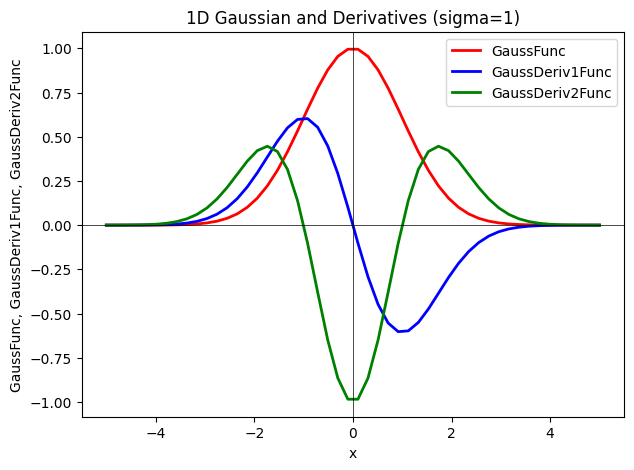

In [8]:
# Con la siguiente figura verificamos que las funciones Gaussianas implementadas son correctas
plt.rcParams["figure.figsize"] = (7,5) # para ajustar tamaño del ancho y alto (ejes)
plt.figure()
xvalues = np.linspace(-5, 5)
yvalues1 = GaussFunc(xvalues,1)
yvalues2 = GaussDeriv1Func(xvalues,1)
yvalues3 = GaussDeriv2Func(xvalues,1)
plt.plot(xvalues, yvalues1, lw=2, color='red',
label='GaussFunc')
plt.plot(xvalues, yvalues2, lw=2, color='blue',
label='GaussDeriv1Func')
plt.plot(xvalues, yvalues3, lw=2, color='green',
label='GaussDeriv2Func')
plt.title('1D Gaussian and Derivatives (sigma=1)')
plt.xlabel('x')
plt.ylabel('GaussFunc, GaussDeriv1Func, GaussDeriv2Func')
plt.axhline(0, lw=0.5, color='black')
plt.axvline(0, lw=0.5, color='black')
plt.legend()

Una vez tenemos las funciones declaradas comprobamos que funcionen correctamente, dibujando sus gráficas, no incluimos factor de normalización y usamos sigma = 1 como se nos indica para obtener la misma gráfica que se nos da para comparar.

Podemos concluir que mis funciones Gaussiana y sus derivadas son correctas.

FIJAMOS PRIMERO EL TAMAÑO DE LA MÁSCARA


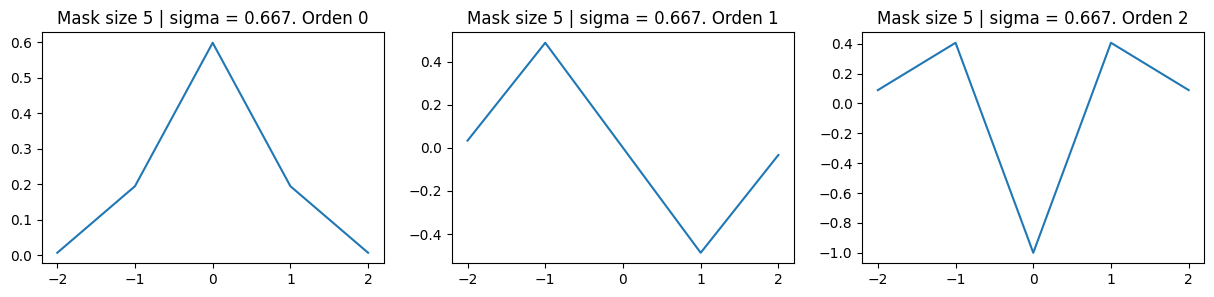

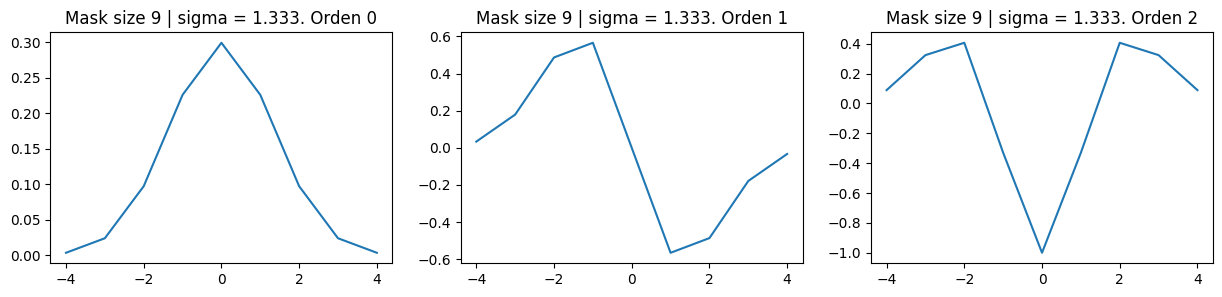

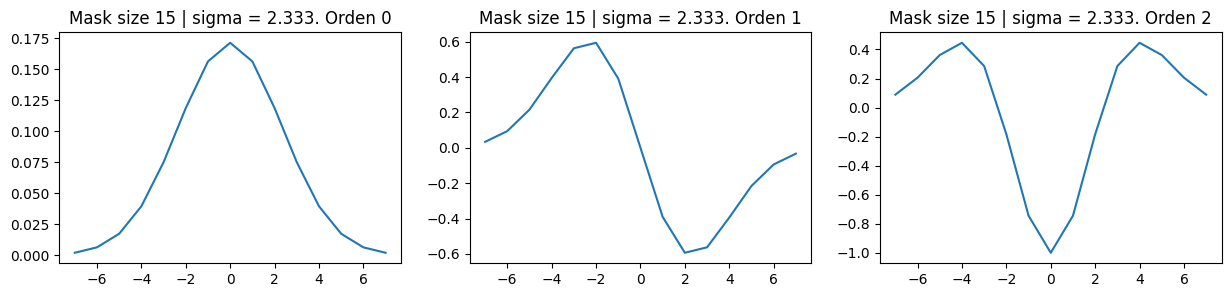

FIJAMOS AHORA EL SIGMA


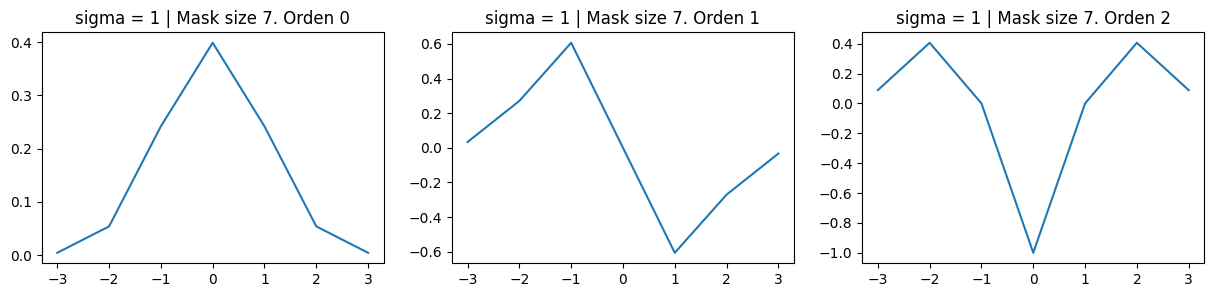

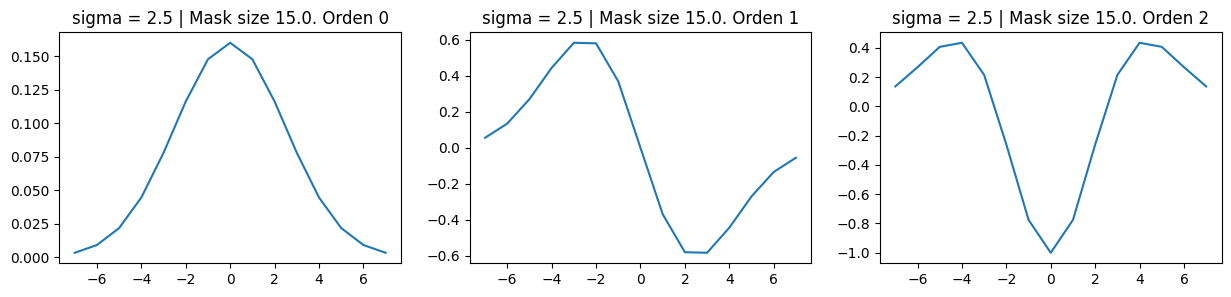

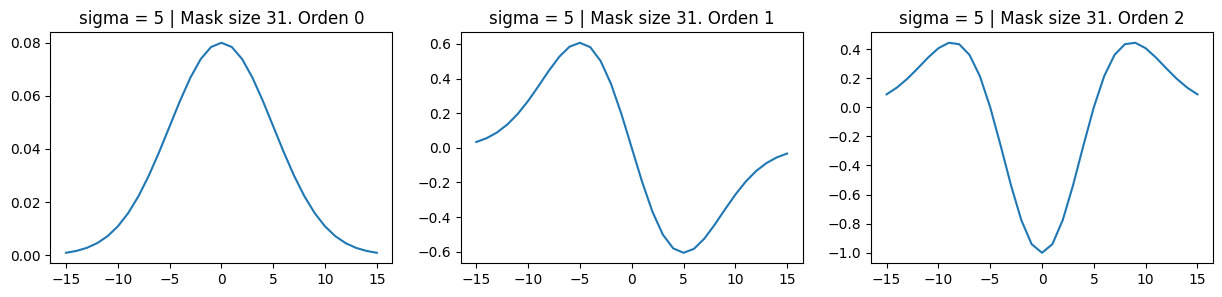

In [9]:
sigma_values = [1, 2.5, 5]
size_masks = [5,9,15]

plt.rcParams["figure.figsize"] = (15,3) # para ajustar tamaño del ancho y alto (ejes)
print('FIJAMOS PRIMERO EL TAMAÑO DE LA MÁSCARA')
for sizeMask in size_masks:
  mask0, sigma0, sizeMask0, xvalues = gaussianMask1D(0, sizeMask, 0, True)
  mask1, sigma1, sizeMask1, xvalues = gaussianMask1D(0, sizeMask, 1, True)
  mask2, sigma2, sizeMask2, xvalues = gaussianMask1D(0, sizeMask, 2, True)

  # Pintamos las gráficas
  fig, axs = plt.subplots(1, 3, figsize=(15, 3))

  axs[0].plot(xvalues, mask0)
  axs[0].set_title(f'Mask size {sizeMask0} | sigma = {sigma0:.3f}. Orden 0')

  axs[1].plot(xvalues, mask1)
  axs[1].set_title(f'Mask size {sizeMask1} | sigma = {sigma1:.3f}. Orden 1')

  axs[2].plot(xvalues, mask2)
  axs[2].set_title(f'Mask size {sizeMask2} | sigma = {sigma2:.3f}. Orden 2')

  plt.show()

print('FIJAMOS AHORA EL SIGMA')
for sigma in sigma_values:
  mask0, sigma0, sizeMask0, xvalues = gaussianMask1D(sigma, 0, 0, True)
  mask1, sigma1, sizeMask1, xvalues = gaussianMask1D(sigma, 0, 1, True)
  mask2, sigma2, sizeMask2, xvalues = gaussianMask1D(sigma, 0, 2, True)

  # Pintamos las gráficas
  fig, axs = plt.subplots(1, 3, figsize=(15, 3))

  axs[0].plot(xvalues, mask0)
  axs[0].set_title(f'sigma = {sigma0} | Mask size {sizeMask0}. Orden 0')

  axs[1].plot(xvalues, mask1)
  axs[1].set_title(f'sigma = {sigma1} | Mask size {sizeMask1}. Orden 1')

  axs[2].plot(xvalues, mask2)
  axs[2].set_title(f'sigma = {sigma2} | Mask size {sizeMask2}. Orden 2')

  plt.show()

A continuación comprobamos el correcto funcionamiento de la función **gaussianMask1D**, para ello probamos pasandole distintos valores de sigma y sizeMask y dibujando los perfiles de las máscaras resultantes a ver si coinciden con los que se nos proporcionan para comprobar.

En un principio no me coincidian las siluetas en los casos de las derivadas de la Gaussiana, por lo que decidí imprimir alguna máscara para ver si encontraba algún fallo, observé entonces que los valores de la máscara no eran los mismos valores duplicados con signo cambiado como debería de ser por el hecho de ser una derivada, donde los valores se anulan entre sí. Por lo que debía haber algún fallo en la función, el fallo era que normalizaba los valores de la máscara aunque fueran de una derivada, lo cual es incorrecto ya que los valores de esas máscaras ya suman 0.

Tras solucionar eso las siluetas ya eran correctas, aunque las escalas de mis siluetas son distintas a las de los ejemplos para comprobar. Esto lo consigo solucionar tras llegar al ejercicio 1.C, donde descubro que debo escalar las máscaras por $σ$ si se trata de la de la primera derivada o por $σ^2$ si se trata de la segunda.

## B) (1.5 puntos)

Lea una imagen en escala de grises y fíltrela mostrando el resultado de la convolución con una Gaussiana, con la primera derivada de la Gaussiana (tanto en X como en Y), y con la segunda derivada de la Gaussiana (tanto en X como en Y). Emplee los siguientes sigmas: $\{0.75,2,5,10,15\}$. Muestra todas las imágenes dentro del mismo canvas, tal y como se muestra más abajo. En este apartado, se debe usar la función de OpenCV `sepFilter2D()` con las máscaras calculadas con las funciones desarrolladas en el apartado anterior.




La convolución con Gaussiana es una operación fundamental en el procesamiento de imágenes y el procesamiento de señales. Se utiliza para suavizar o desenfocar una imagen, lo que implica reducir el ruido y las transiciones abruptas en la intensidad de los píxeles.

La operación de convolución con Gaussiana funciona de la siguiente manera:

* Definición de la Máscara Gaussiana: Primero, se define una máscara o kernel Gaussiano, que es una representación discreta de la función Gaussiana. La máscara Gaussiana se crea calculando los valores de la función Gaussiana para diferentes puntos en un dominio discreto. Lo conseguimos con la función anteriormente construida **gaussianMask1D**.

* Colocación de la Máscara: La máscara Gaussiana se coloca sobre la imagen de entrada de tal manera que su centro se alinee con el píxel actual que se está procesando.

* Operación de Convolución: Para cada píxel en la imagen de entrada, se realiza una operación de convolución. En esta operación, se multiplica el valor de cada píxel de la máscara Gaussiana por el valor correspondiente en la imagen de entrada. Luego, se suman todos estos productos para obtener el nuevo valor del píxel en la imagen de salida.

* Repetición para Todos los Píxeles: Este proceso se repite para todos los píxeles en la imagen de entrada. La convolución se realiza de manera similar en todas las regiones de la imagen.

* Resultado Suavizado: El resultado es una nueva imagen en la que los píxeles se han suavizado o desenfocado de acuerdo con la función Gaussiana. Los píxeles cercanos entre sí tienen valores más similares después de la convolución, lo que reduce el ruido y suaviza las transiciones bruscas en la imagen.

La desviación estándar $σ$ de la función Gaussiana controla la cantidad de suavizado aplicado. Un valor de $σ$ más grande produce un suavizado más fuerte, mientras que un valor de $σ$ más pequeño produce un suavizado más suave.

Para el resto de pasos de la convolución usamos la función sepFilter2D() de la biblioteca OpenCV. Se utiliza para realizar una convolución separable 2D en una imagen utilizando dos núcleos 1D en lugar de un solo núcleo 2D completo. Esto es especialmente eficiente en términos de rendimiento computacional cuando se trabaja con máscaras de convolución que tienen una dimensión grande, aunque no es nuestro caso como en nuestra función para generar las máscaras hacemos uso de la separabilidad de los filtros, convolucionamos primero en una dirección y luego en la otra, usamos esta función.

Los argumentos de la función son los siguientes:

* src: La imagen de entrada en la que se realizará la convolución.

* ddepth: La profundidad de bits de la imagen de salida. Puede ser cv2.CV_8U, cv2.CV_16U, cv2.CV_16S, cv2.CV_32F, o cv2.CV_64F, dependiendo de la precisión deseada en la salida. Este parámetro es bastante importante, en nuestro caso lo fijamos en cv2.CV_64F, para operar en coma flotante con 64 bits y así evitar posibles problemas de truncamiento.

* kernelX: El núcleo 1D que se aplicará en la dirección horizontal (columnas).

* kernelY: El núcleo 1D que se aplicará en la dirección vertical (filas).

Con la ayuda de esta función creamos el método **my2DConv** que se encarga de realizar la convolución 2D de una imagen que se le introduzca por parámetro, también se le puede especificar el sigma y que orden de la gaussiana usar para la máscara y en que dimensión aplicar la misma.

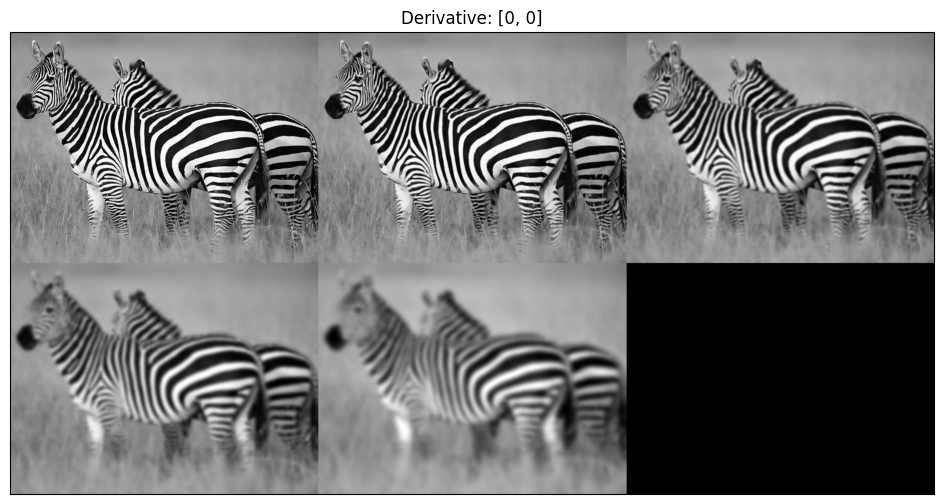

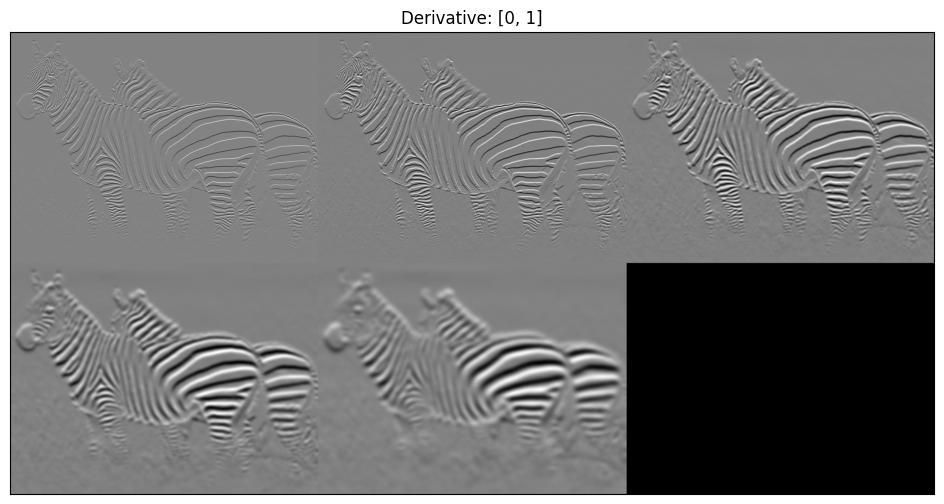

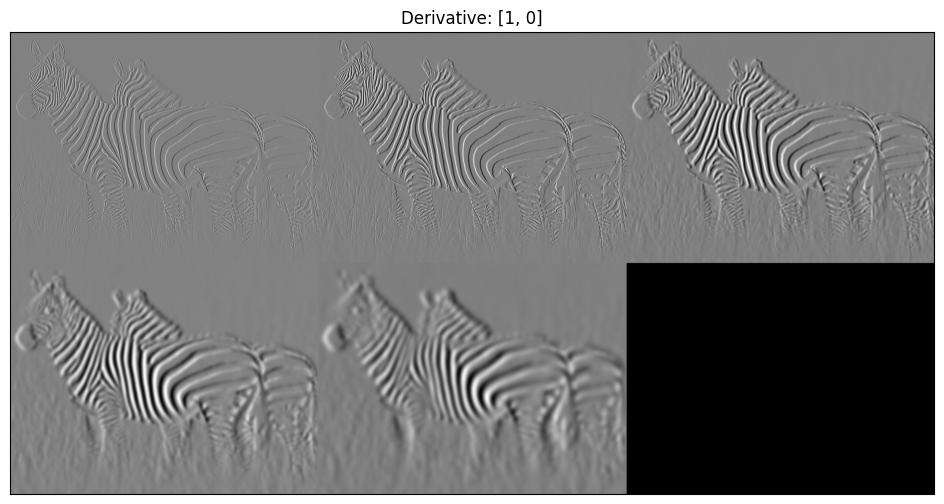

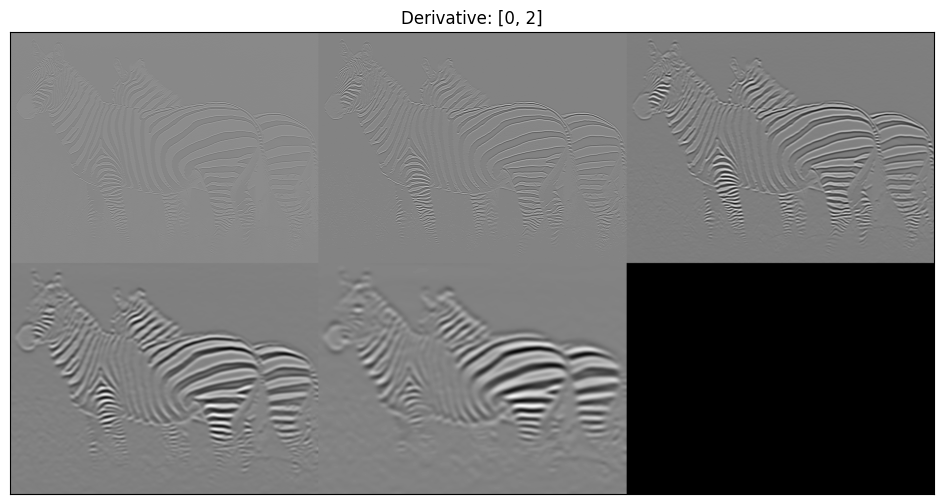

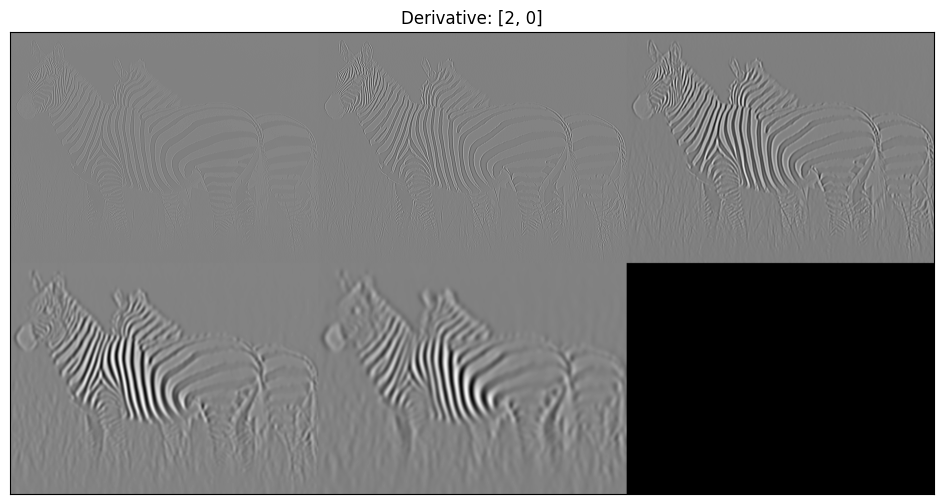

In [10]:
def my2DConv(im, sigma, orders):
  ddepth=cv2.CV_64F
  maskG=gaussianMask1D(sigma, order=0)
  maskDG=gaussianMask1D(sigma, order=1)
  mask2DG= gaussianMask1D(sigma, order=2)
  if orders==[0,0]: # Suavizado Gaussiano
    return cv2.sepFilter2D(im, ddepth, maskG, maskG)
  elif orders == [1, 0]: # Primera derivada en x
    return cv2.sepFilter2D(im, ddepth, maskDG, maskG)
  elif orders == [0, 1]: # Primera derivada en y
    return cv2.sepFilter2D(im, ddepth, maskG, maskDG)
  elif orders == [2, 0]: # Segunda derivada en x
    return cv2.sepFilter2D(im, ddepth, mask2DG, maskG)
  elif orders == [0, 2]: # Segunda derivada en y
    return cv2.sepFilter2D(im, ddepth, maskG, mask2DG)
  else:
    print('error in order of derivative')

# let's check the function
im=cv2.imread(get_image('zebra.jpg'),0)
vim0=[]
orders=[[0,0], [0,1], [1,0], [0,2], [2,0]]

for orden in orders:
  for sigma in [0.75,2,5,10,15]:
    vim0.append(rangeDisplay01(my2DConv(im,sigma,orden),True))

  displayMI_ES(vim0,f'Derivative: {orden}',2)
  vim0=[] # Eliminamos imágenes anteriores




Probamos con la imagen zebra.jpg si nuestra función **my2DConv** funciona correctamente, para un order[0, 0] observamos que según aumentamos el valor de sigma, la imagen se va suavizando cada vez más. Estas imágenes coinciden con las del ejemplo y su comportamiento con lo que comento en el apartado A) sobre que la Gaussiana sirve para suavizar la imagen, por lo que considero que esta parte es correcta.

Si usamos para la máscara la primera derivada, podemos observar como se resaltan los bordes y zonas donde existe un cambio de intensidad en la imagen, de nuevo considero correcto este apartado, ya que se corresponde con las imágenes del ejemplo, así como con la función de la primera derivada de la Gaussiana, la cual es básicamente detección de bordes.

Por último usando la máscara de la segunda derivada, observamos que los bordes se resaltan con aún más fuerza, concuerda de nuevo tanto con la parte teórica, como con el ejemplo proporcionado, por lo que entiendo que la función **my2DConv** funciona perfectamente.

## C) (1 punto)

Emplee la función de OpenCV `sepFilter2D()` y $\sigma=3.0$ para calcular el gradiente (4 imágenes: derivada en X, derivada en Y, magnitud y orientación) y la Laplaciana de la Gaussiana.

In [11]:
# Calculamos kernel 1D
sigma = 3
maskG=gaussianMask1D(sigma, order=0)
maskDG=gaussianMask1D(sigma, order=1)
mask2DG= gaussianMask1D(sigma, order=2)

# Generamos las imágenes
ddepth=cv2.CV_64F

# Primera derivada en x
Gx = cv2.sepFilter2D(im, ddepth, maskDG, maskG)
derX = rangeDisplay01(Gx)

# Primera derivada en y
Gy = cv2.sepFilter2D(im, ddepth, maskG, maskDG)
derY = rangeDisplay01(Gy)

# Magnitud del gradiente
aux = np.sqrt(Gx**2 + Gy**2)
magnitud = rangeDisplay01(aux)

# Orientación del gradiente
aux = np.arctan2(Gy, Gx)
orientacion = rangeDisplay01(aux)

# Laplaciana de la Gaussiana
G_x = cv2.sepFilter2D(im, ddepth, mask2DG, maskG)
G_y = cv2.sepFilter2D(im, ddepth, maskG, mask2DG)

aux = sigma**2 * (G_x + G_y)
Laplaciana = rangeDisplay01(aux)

# Muestra las imágenes
displayIm(derX, 'derX')
displayIm(derY, 'derY')
displayIm(magnitud, 'magnitud')
displayIm(orientacion, 'orientacion')
displayIm(Laplaciana, 'Laplaciana')

Output hidden; open in https://colab.research.google.com to view.

En esta última parte del ejercicio 1 se nos pide que calculemos el gradiente y la Laplaciana de la Gaussiana.

Para los dos primeros casos, gradientes en X e Y, simplemente hacemos como en el apartado anterior y usando el kernel 1D horizontal o vertical (dependiendo del caso) y la función sepFilter2D() obtenemos sus respectivas imágenes calculadas.

En el caso de la magnitud del gradiente, a partir de los gradientes en X e Y ya calculados, los elevamos al cuadrado, sumamos y calculamos su raiz cuadrada, la cual nos da la magnitud del gradiente. La fórmula es la siguiente:

$G = \sqrt{G_x^2+G_y^2}$

Con la orientación del gradiente ocurre algo similar, lo calculamos de nuevo a partir de los gradientes en X e Y, esta es su fórmula:

$atan2(G_x, G_y)$

Por último para calcular la Laplaciana debemos calcular primero la convolución por filas con la derivada segunda de la Gaussiana, multiplicarla por la convolución por columnas con la Gaussiana y ese resultado sumarlo al resultado de calcular la convolución por filas con la Gaussiana multiplicada por la convolución por columnas con la derivada segunda de la Gaussiana. Por último el resultado final se multiplica por $σ^2$ y obtenemos la Laplaciana.

En cuanto a sus utilidades, ya conocemos los usos más comunes de los gradientes en X e Y. Para el resto estas son sus características principales:

* **La magnitud del gradiente** mide la intensidad del cambio en la intensidad de los píxeles en una imagen en un punto dado. Sus principales aplicaciones son:
> * Detección de bordes: La magnitud del gradiente se utiliza para detectar bordes y transiciones en una imagen. Donde la magnitud es alta, suele haber un borde.
> * Realce de características: Puede usarse para realzar detalles y características importantes en una imagen.
> * Extracción de características: Se utiliza en algoritmos que buscan puntos clave o regiones de interés en una imagen, como el detector de esquinas Harris.

* **La orientación del gradiente** describe la dirección en la que se produce el cambio de intensidad máxima en un punto de la imagen. Estas son sus principales aplicaciones:
> * Detección de bordes direccionales: Ayuda a identificar la dirección de los bordes detectados en una imagen.
> * Realce de características orientadas: Se utiliza en aplicaciones donde la orientación de las características es importante, como la detección de texturas.

* **La Laplaciana** es una medida de la variación espacial de la intensidad de los píxeles en una imagen. Sus usos más comunes son los siguientes:
> * Detección de características: Se utiliza para resaltar puntos de interés en una imagen, como esquinas y regiones de alta variación.
> * Detección de áreas planas: La Laplaciana resalta las regiones con intensidad constante o cambios suaves.

# **Ejercicio 2**:  Pirámides Gaussianas y Laplacianas (3 points)







## A) (1.5 puntos)

Construya una pirámide Gaussiana de 4 niveles empleando máscaras Gaussianas de tamaño 7x7. No se permite emplear las funciones `pyrUp()` y `pyrDown()` de OpenCV.

Las pirámides gaussianas son una técnica de procesamiento de imágenes utilizada para representar una imagen en múltiples escalas de resolución. Estas pirámides se crean mediante la aplicación de operaciones de suavizado y submuestreo a una imagen original.

Las pirámides gaussianas son útiles en una variedad de aplicaciones, como detección de bordes, seguimiento de objetos, reducción de ruido, detección de características y escalado de imágenes.

In [12]:
'''
This function displays a pyramid of images, providing as input the list of images to display.

Example of use:
im1=readIm(get_image('apple.jpg'),1)
images = [im1, cv2.resize(im1,(im1.shape[0]//2,im1.shape[1]//2),cv2.INTER_LINEAR), cv2.resize(im1,(im1.shape[0]//4,im1.shape[1]//4),cv2.INTER_LINEAR), cv2.resize(im1,(im1.shape[0]//8,im1.shape[1]//8),cv2.INTER_LINEAR), cv2.resize(im1,(im1.shape[0]//16,im1.shape[1]//16),cv2.INTER_LINEAR)]

displayPyramid(images, title='Piramide de Manzanas')

'''
def displayPyramid(vim, title='result'):
  temp = np.zeros_like(vim[0])
  if np.mod(temp.shape[1],2)==0:
    h = temp[:, :temp.shape[1]//2]
  else:
    h = temp[:, :(temp.shape[1]//2)+1]
  out = np.hstack((temp, h))
  top = 0
  out[0:vim[0].shape[0], 0:vim[0].shape[1]] = vim[0]
  left = vim[0].shape[1]
  for i in range(1, len(vim)):
    out[top:top+vim[i].shape[0], left:left + vim[i].shape[1]] = vim[i]
    top += vim[i].shape[0]
  displayIm(out, title)

Los pasos a la hora de construir la pirámide gaussiana de una imagen son simples:

* Suavizado Gaussiano: En cada nivel de la pirámide, se aplica un filtro Gaussiano para suavizar la imagen. El suavizado reduce el ruido y elimina detalles finos de la imagen.

* Submuestreo: Después del suavizado, la imagen se submuestrea (se reduce) en tamaño. Esto implica tomar cada segundo píxel en la horizontal y vertical o realizar un promedio de los píxeles en un área cercana. El submuestreo reduce la resolución de la imagen pero conserva las características principales.

* Múltiples Niveles: La pirámide gaussiana puede tener varios niveles, cada uno con una versión suavizada y submuestreada de la imagen original. A medida que subes en la pirámide, la resolución disminuye y la imagen se vuelve más pequeña.

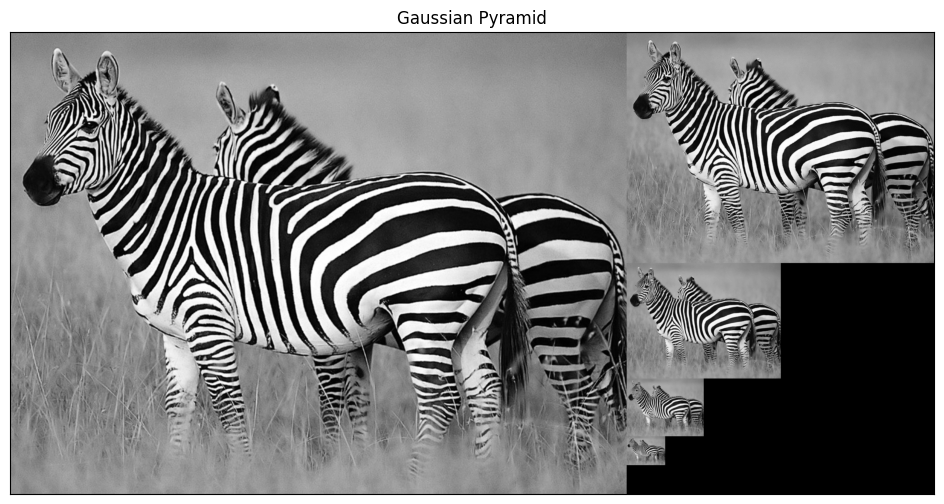

In [13]:
def pyramidGauss(im,sizeMask=7, nlevel=4):
  vim=[im]
  ddepth=cv2.CV_64F
  maskG=gaussianMask1D(sizeMask=sizeMask, order=0)

  for i in range(nlevel):
    im = cv2.sepFilter2D(im, ddepth, maskG, maskG) # Suavizamos
    im = im[::2, ::2]  # Submuestreamos la imagen
    vim.append(im)

  return vim

im=cv2.imread(get_image('zebra.jpg'),0)
pyrG = pyramidGauss(im,sizeMask=7, nlevel=4)
displayPyramid(pyrG,'Gaussian Pyramid')


Podemos observar como a medida que reducimos la imagen podemos hasta cierto punto conservar la calidad de la imagen original, cosa que no seríamos capaces de conseguir si simplemente submuestreáramos la imagen eliminando filas y columnas, en cuyo caso la imagen empezaría a perder calidad mucho más rápido.


## B) (1 punto)

Use su código del apartado anterior para implementar una función que permita construir una pirámide Laplaciana de 4 niveles.

La pirámide Laplaciana es una técnica en procesamiento de imágenes que se utiliza para representar una imagen en múltiples escalas de detalle. A diferencia de la pirámide Gaussiana, que se centra en la representación de diferentes escalas de suavizado, la pirámide Laplaciana se enfoca en representar diferentes escalas de detalle en una imagen.

Esta se construye tomando la diferencia entre cada nivel de la pirámide Gaussiana y su versión expandida. Cada nivel de la pirámide Laplaciana contiene información de detalle a una escala específica. Los niveles más bajos contienen detalles finos, mientras que los niveles más altos contienen detalles más gruesos.

Es útil en aplicaciones de procesamiento de imágenes como la compresión de imágenes, la eliminación de ruido, la detección de bordes y la representación eficiente de detalles de diferentes escalas.

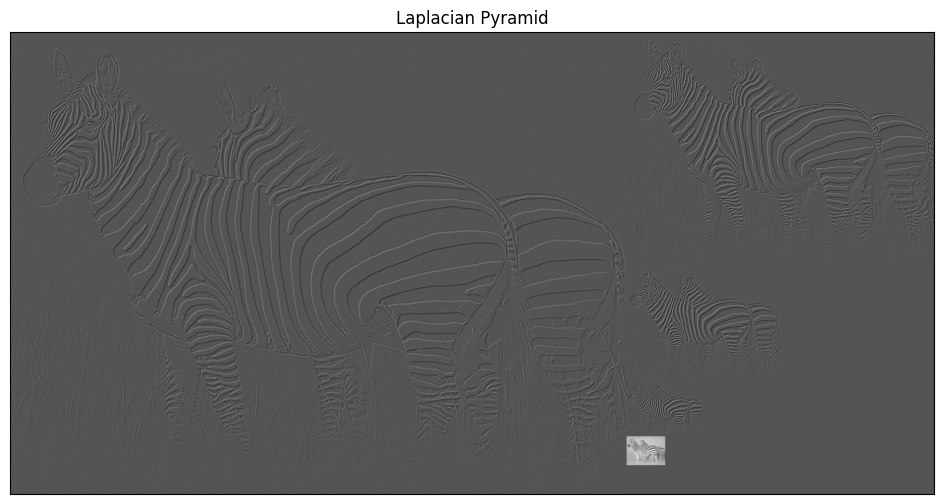

In [14]:
def pyramidLap(im, sizeMask, nlevel=4, flagInterp=cv2.INTER_LINEAR):
    vimG = pyramidGauss(im, sizeMask=sizeMask, nlevel=nlevel)
    vimL = []

    for i in range(nlevel):
        expanded = cv2.resize(vimG[i + 1], (vimG[i].shape[1], vimG[i].shape[0]), interpolation=flagInterp)
        laplacian = vimG[i] - expanded
        vimL.append(laplacian)

    vimL.append(vimG[-1])  # Agrega la imagen de nivel más bajo a la pirámide Laplaciana

    return vimL

im=cv2.imread(get_image('zebra.jpg'),0)
pyrL = pyramidLap(im,sizeMask=7, nlevel=4)
displayPyramid(pyrL,'Laplacian Pyramid')

La construcción de la función es bastante trivial, una vez conocemos que la pirámide laplaciana se construye tomando la diferencia entre cada nivel de la pirámide Gaussiana y la versión expandida de sí misma.

A la hora de expandir las imágenes usamos la función resize() de cv2, a la cual le pasamos como argumentos la imagen a modificar, las nuevas dimensiones que va a tener y el tipo de interpolación, en nuestro caso siempre es cv2.INTER_LINEAR, esta constante hace referencia a una interpolación lineal.

Este método considera los píxeles más cercanos al punto de destino y calcula un valor ponderado para el píxel de destino basado en su posición relativa a los píxeles conocidos circundantes.

Que mi pirámide laplaciana no se corresponda con la del ejemplo es debido a como tengo implementado el subsample y el upsample. Mientras que para el primero voy eliminando filas y columnas pares, la implementación del upsample se basa en realizar interpolación lineal.

Al usar dos métodos distintos para reducir y aumentar el tamaño de la imagen, el resultado no es el que debería.

Aunque esta forma se dé por válida a continuación implementaré la que se supone más correcta, modificando el upsample para que rellene las filas y columnas intermedias con 0s y a continuación aplique un filtro gaussiano para rellenar sus valores en función de lo que tienen alrededor.

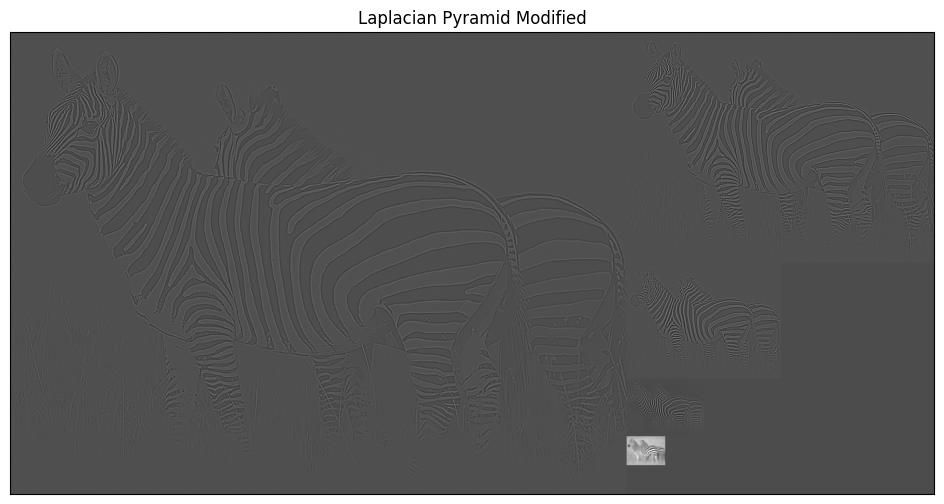

In [15]:
def pyramidLapMod(im, sizeMask, nlevel=4):
    vimG = pyramidGauss(im, sizeMask=sizeMask, nlevel=nlevel)
    vimL = []

    ddepth=cv2.CV_64F
    maskG=gaussianMask1D(sizeMask=sizeMask, order=0)

    for i in range(nlevel):
        expanded = np.zeros((vimG[i].shape[0], vimG[i].shape[1]), dtype=np.uint8)
        expanded[::2, ::2] = vimG[i+1]

        # Aplicar filtro gaussiano para rellenar los valores intermedios
        expanded = cv2.sepFilter2D(expanded, ddepth, maskG, maskG)

        # Normalizar la matriz expanded
        expanded = (expanded - expanded.min()) / (expanded.max() - expanded.min()) * 255.0

        laplacian = vimG[i] - expanded
        vimL.append(laplacian)

    vimL.append(vimG[-1])  # Agrega la imagen de nivel más bajo a la pirámide Laplaciana

    return vimL


im=cv2.imread(get_image('zebra.jpg'),0)
pyrL = pyramidLapMod(im,sizeMask=7, nlevel=4)
displayPyramid(pyrL,'Laplacian Pyramid Modified')

Ahora si sale como en el ejemplo salvo por la tonalidad, aquí es más oscura, supongo que se debe al normalizar, no uso la normalización adecuada y el resultado de la resta acaba siendo valores menores a los que deberían darse, de ahí que la imagen sea más oscura.

## C) (0.5 puntos)

Implemente ahora una función para reconstruir la imagen codificada en la pirámide Laplaciana. Verifique que es posible obtener una copia exacta de la imagen original. Para ello, calcule el error de reconstrucción como la norma Euclídea de las diferencias entre los niveles de intensidad de la imagen original y la imagen reconstruida.

La pirámide Laplaciana se puede utilizar para reconstruir la imagen original. La reconstrucción comienza con el nivel más bajo y se agregan los detalles de cada nivel superior de manera ascendente.

El procedimiento a seguir es el siguiente:
* Empezamos con la imagen más pequeña de la pirámide laplaciana.
* Aumentamos su tamaño a la escala de la siguiente imagen de la pyL.
* Sumamos esa imagen con la expandida.
* La imagen resultante la volvemos a expandir y así sucesivamente hasta completar todos los niveles.

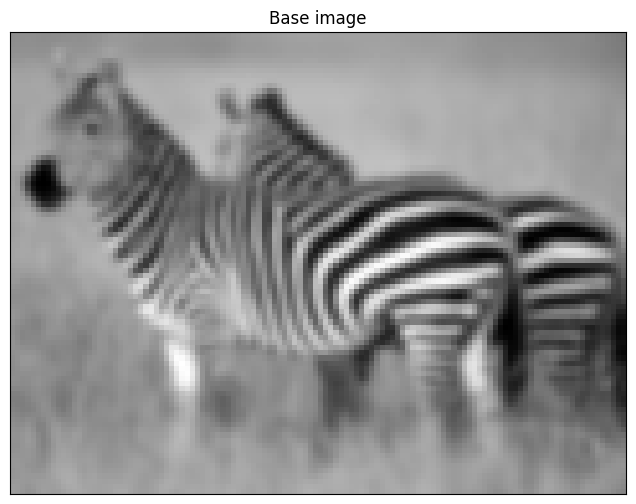

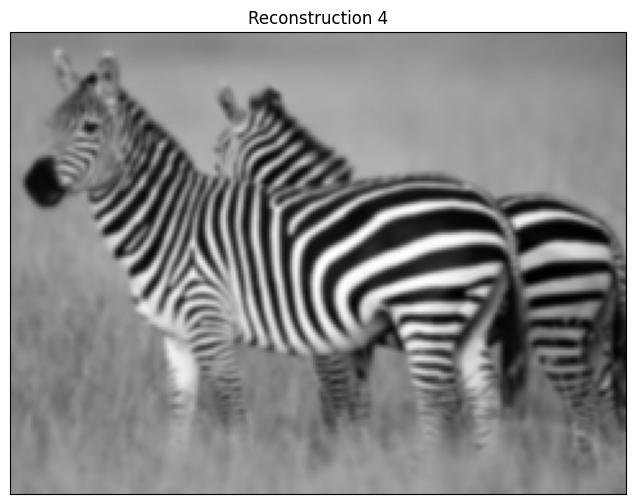

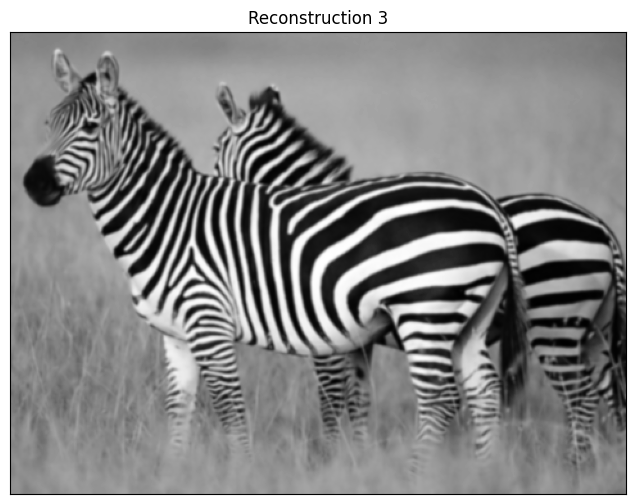

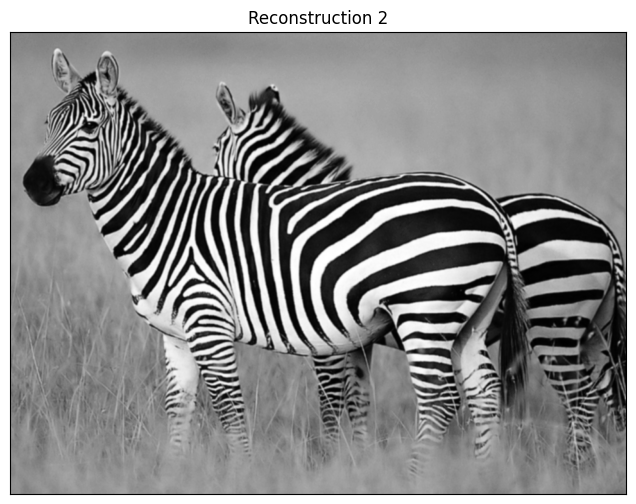

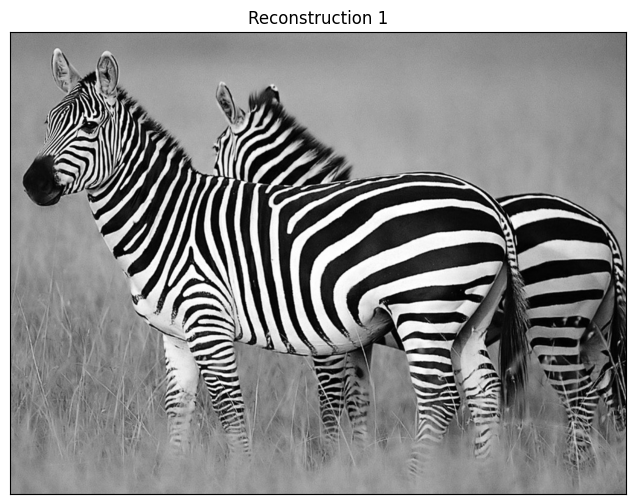

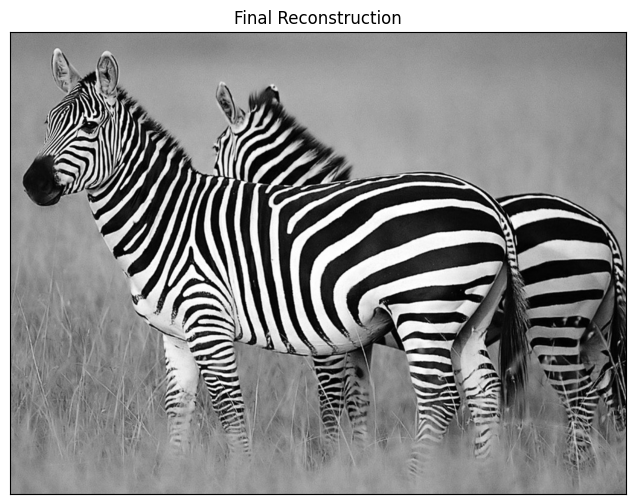

Error per pixel 0.0


In [16]:
def reconstructLap(pyL,flagInterp):
  nlevel = len(pyL)
  im_reconstructed = pyL[-1]  # Comenzamos con la imagen de nivel más bajo
  displayIm(im_reconstructed, "Base image")  # Mostramos la imagen

  for i in range(nlevel - 2, -1, -1):
    expanded = cv2.resize(im_reconstructed, (pyL[i].shape[1], pyL[i].shape[0]), interpolation=flagInterp)
    im_reconstructed = pyL[i] + expanded
    displayIm(im_reconstructed, "Reconstruction " + str(i+1))

  return im_reconstructed

im=cv2.imread(get_image('zebra.jpg'),0)
pyramid_laplacian = pyramidLap(im, sizeMask=11)
recons = reconstructLap(pyramid_laplacian, cv2.INTER_LINEAR)

displayIm(recons, "Final Reconstruction")
print('Error per pixel',np.sqrt(np.linalg.norm(im-np.round(recons), ord=2)/np.prod(im.shape)))

Se puede calcular el error de reconstrucción comparando la imagen original con la imagen reconstruida a partir de la pirámide Laplaciana. La norma Euclidiana de las diferencias entre píxeles se utiliza comúnmente para evaluar la calidad de la reconstrucción.

En nuestro caso observamos que el error por pixel es nulo, por lo que la reconstrucción de la imagen ha sido perfecta.

# **Ejercicio 3: Imágenes Híbridas** (2 puntos)

Este ejercicio se basa en el siguiente trabajo: $\textit{Oliva, A., Torralba, A., & Schyns, P. G. (2006). Hybrid images. ACM Transactions on Graphics (TOG), 25(3), 527-532}$. (https://stanford.edu/class/ee367/reading/OlivaTorralb_Hybrid_Siggraph06.pdf).  

El objetivo es aprender cómo el sistema visual humano extrae información sobre un objeto en función de la distancia. Para ello, construimos una imagen híbrida a partir de dos imágenes de objetos diferentes. Mezclando adecuadamente parte de las altas frecuencias de una imagen con parte de las bajas frecuencias de otra imagen, obtenemos una imagen híbrida que muestra diferentes percepciones con la distancia. El sigma empleado para filtrar ambas imágenes (tanto la de alta como la de bajas frecuencias) es el aspecto clave para seleccionar el rango de frecuencias altas y bajas de cada imagen. Cuanto mayor sea el valor sigma, mayor será la eliminación de altas frecuencias de la imagen. Se recomienda elegir este valor por separado para cada una de las imágenes y, de hecho, seguramente sea posible (y deseable) el tener distintos valores para distintos pares de imágenes. Recuerde emplear la pirámide Gaussiana para mostrar el efecto obtenido.

Para construir la función solicitada, simplemente seguimos los pasos que nos indican, primero aplico el filtro gaussiano a las dos imágenes a mezclar, image1 corresponde con la imagen que tenga un aspecto más suavizado, es decir la imagen de baja frecuencia e image2 la de alta frecuencia.

La image1 modificada será el resultado de alisar fuertemente image1 y la image2 modificada la diferencia entre image2 y su versión suavizada, cada una de las dos imágenes tiene su propio valor sigma para así poder controlar que tan potente realizar el suavizado por separado.

Por último creo la imagen híbrida que es el resultado de sumar ambas imágenes y dividir entre dos, es decir la media de ambas, y devuelvo la imagen.

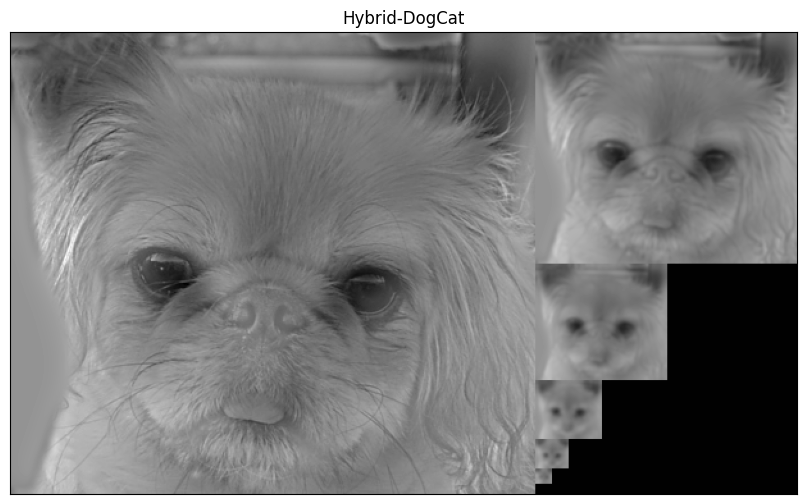

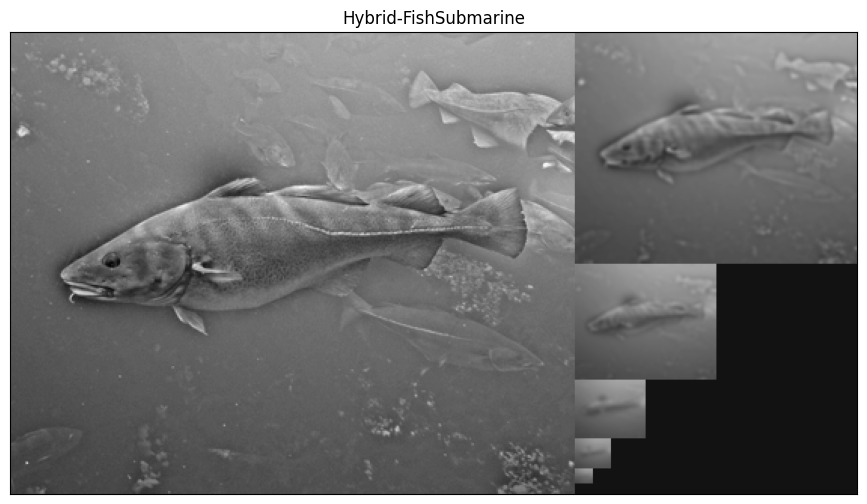

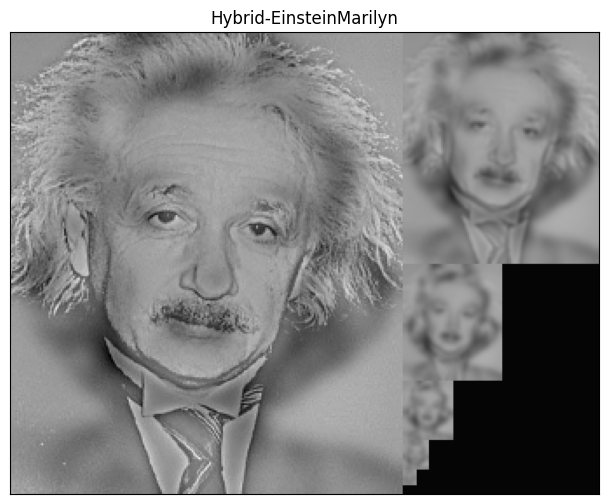

In [17]:
# Función para crear una imagen híbrida a partir de dos imágenes y valores de sigma
def createHybridImage(image1, image2, sigma_low, sigma_high, verbose=False):
    # Aplicar filtro Gaussiano a ambas imágenes
    ddepth=cv2.CV_64F
    maskG_low=gaussianMask1D(sigma=sigma_low, order=0)
    maskG_high=gaussianMask1D(sigma=sigma_high, order=0)

    image1_low = cv2.sepFilter2D(image1, ddepth, maskG_low, maskG_low)
    image2_high = image2 - cv2.sepFilter2D(image2, ddepth, maskG_high, maskG_high)

    # Combinar las imágenes filtradas
    hybrid_image = image1_low + image2_high
    hybrid_image /= 2

    if verbose:
      displayIm(image1_low, "image1_low")
      displayIm(image2_high, "image2_high")

    return hybrid_image


# Cargar las imágenes a combinar
cat = cv2.imread(get_image('cat.bmp'),0)
dog = cv2.imread(get_image('dog.bmp'),0)
fish = cv2.imread(get_image('fish.bmp'),0)
submarine = cv2.imread(get_image('submarine.bmp'),0)
einstein = cv2.imread(get_image('einstein.bmp'),0)
marilyn = cv2.imread(get_image('marilyn.bmp'),0)

# Crear las imágenes híbridas
cat_dog = createHybridImage(cat, dog, 10, 5)
submarine_fish = createHybridImage(submarine, fish, 10, 5)
marilyn_einstein = createHybridImage(marilyn, einstein, 5, 3)

# Crear la pirámide Gaussiana para la imagen híbrida
cat_dog_pyramid = pyramidGauss(cat_dog,sizeMask=13, nlevel=5)
submarine_fish_pyramid = pyramidGauss(submarine_fish,sizeMask=13, nlevel=5)
marilyn_einstein_pyramid = pyramidGauss(marilyn_einstein,sizeMask=13, nlevel=5)

# Mostrar las pirámides
displayPyramid(cat_dog_pyramid,'Hybrid-DogCat')
displayPyramid(submarine_fish_pyramid,'Hybrid-FishSubmarine')
displayPyramid(marilyn_einstein_pyramid,'Hybrid-EinsteinMarilyn')


A la hora de usar la función con las imágenes de ejemplo, simplemente la más suavizada la paso como parámetro image1 y la que presenta bordes más acentuados como image2. En general con aplicar un fuerte suavizado a image1 (sigma alto) he obtenido buenos resultados, salvo en el caso de Marilyn, donde al aplicar un sigma = 10 la imagen estaba suavizada y no se lograba ver bien, solo se veía una mancha, simplemente reducí su sigma un poco y el resultado fue el correcto.

# **Ejercicio 4: Pyramid Blending** (1 punto)

En este ejercicio se debe crear la imagen fusionada (horizontal) de la manzana (`apple.jpg`) y la naranja (`orange.jpg`) empleando la técnica de $\textit{Pyramid Blending}$. Para este ejercicio, si se desea, sí se pueden emplear las funciones de OpenCV `pyrDown` y `pyrUp`. Para que el ejercicio puntúe, es esencial explicar en detalle el proceso seguido a la hora de crear la nueva imagen (mezcla de ambas). El resultado debe ser similar al mostrado en la celda de resultados correspondiente.  



Pyramid Blending es una técnica en procesamiento de imágenes que combina dos imágenes de manera suave y gradual utilizando pirámides de imágenes. Esta técnica se utiliza para lograr transiciones suaves entre dos imágenes, como fusionar dos imágenes en una sola de manera que no se perciba una transición brusca.

El proceso de Pyramid Blending implica los siguientes pasos:

* Creación de pirámides: Se generan pirámides Laplacianas para ambas imágenes.

* Mezcla de pirámides: Las pirámides Laplacianas de ambas imágenes se combinan de manera adecuada, normalmente tomando la mitad de las filas y columnas de una imagen y la otra mitad de la otra imagen.

* Reconstrucción: Se reconstruye la imagen final a partir de la pirámide mezclada utilizando una pirámide Gaussiana inversa.

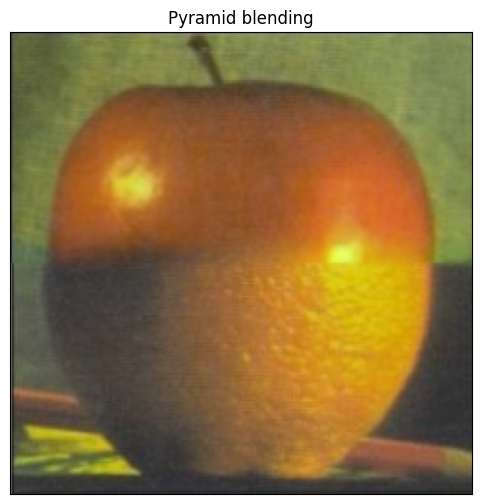

In [18]:
# Leemos las imágenes a color
im1 = readIm(get_image('apple.jpg'),1)
im2 = readIm(get_image('orange.jpg'),1)

# Las imágenes no tienen exactamente la misma dimensión, redimensiono
height, width, aux = im2.shape
im1 = cv2.resize(im1, (width, height))

# Calculamos las pirámides laplacianas
levels = 4
sizeMask = 11

im1lap = pyramidLap(im1, sizeMask, levels)
im2lap = pyramidLap(im2, sizeMask, levels)

# Mezclamos ambas laplacianas
merged_pyramid = []

for i in range(levels+1):
  height = im1lap[i].shape[0]
  half_height = height // 2

  upside_half = im1lap[i][:half_height, :]
  downside_half = im2lap[i][half_height:, :]
  merged_level = np.vstack((upside_half, downside_half))
  merged_pyramid.append(merged_level)

# Reconstruimos la imagen
def reconstructLap(pyL,flagInterp):
  nlevel = len(pyL)
  im_reconstructed = pyL[-1]  # Comenzamos con la imagen de nivel más bajo

  for i in range(nlevel - 2, -1, -1):
    expanded = cv2.resize(im_reconstructed, (pyL[i].shape[1], pyL[i].shape[0]), interpolation=flagInterp)
    im_reconstructed = pyL[i] + expanded

  return im_reconstructed

recons = reconstructLap(merged_pyramid, cv2.INTER_LINEAR)

displayIm(recons, "Pyramid blending")

Podemos observar la transición de naranja a manzana en el resultado, no es un corte basto resultado de simplemente pegar la mitad superior de una imagen junto con la mitad inferior de la otra. Con respecto a la imagen de ejemplo, esa está más suavizada, aunque entiendo que es producto de como está codificada la función para crear la pirámide laplaciana, al final la transición de manzana a naranja si se aprecia bien construida en ambos casos.